In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import re

In [11]:
train=pd.read_csv("C:\\Users\\Dell\\Desktop\\GDZ Elektrik Datathon\\new_train2.csv")
test=pd.read_csv("C:\\Users\\Dell\\Desktop\\GDZ Elektrik Datathon\\new_test2.csv")
submission=pd.read_csv("C:\\Users\\Dell\\Desktop\\GDZ Elektrik Datathon\\sample_submission.csv")

In [12]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

train = encode(train, 'yil', 365)
train = encode(train, 'ay', 12)
train = encode(train, 'haftanin_gunu', 7)

test = encode(test, 'yil', 365)
test = encode(test, 'ay', 12)
test = encode(test, 'haftanin_gunu', 7)

In [13]:
silinecek_sutunlar=["yil","ay","haftanin_gunu","bildirimli_sum","tarih","mevsim","min_t_2m:C","max_t_2m:C",'mean_t_2m:C',
                    't_difference_2m:C','min_t_apparent:C','max_relative_humidity_2m:p','t_apparent_difference:C','max_global_rad:W',
                    'max_t_apparent:C','mean_t_apparent:C','tatil_mi']
train_df=train.drop(silinecek_sutunlar,axis=1)
test_df=test.drop(silinecek_sutunlar,axis=1)

In [14]:
train_df=train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train_df=pd.get_dummies(data=train_df, prefix="ilce", dtype="int")
train_df.head()

,bildirimsiz_sum,max_wind_speed_10mms,max_prob_precip_1hp,yil_sin,yil_cos,ay_sin,ay_cos,haftanin_gunu_sin,haftanin_gunu_cos,ilce_izmir-aliaga,...,ilce_manisa-koprubasi,ilce_manisa-kula,ilce_manisa-salihli,ilce_manisa-sarigol,ilce_manisa-saruhanli,ilce_manisa-sehzadeler,ilce_manisa-selendi,ilce_manisa-soma,ilce_manisa-turgutlu,ilce_manisa-yunusemre
0,5.0,6.4,1.0,-0.230306,-0.973118,0.5,0.866025,-0.433884,-0.900969,1,...,0,0,0,0,0,0,0,0,0,0
1,10.0,8.5,1.0,-0.230306,-0.973118,0.5,0.866025,-0.433884,-0.900969,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,5.7,6.7,-0.230306,-0.973118,0.5,0.866025,-0.433884,-0.900969,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,3.6,3.1,-0.230306,-0.973118,0.5,0.866025,-0.433884,-0.900969,0,...,0,0,0,0,0,0,0,0,1,0
4,5.0,1.5,1.0,-0.230306,-0.973118,0.5,0.866025,-0.433884,-0.900969,0,...,0,0,1,0,0,0,0,0,0,0


In [15]:
test_df=pd.get_dummies(data=test_df, prefix="ilce", dtype="int")
test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df.head()

,max_wind_speed_10mms,max_prob_precip_1hp,yil_sin,yil_cos,ay_sin,ay_cos,haftanin_gunu_sin,haftanin_gunu_cos,ilce_izmiraliaga,ilce_izmirbalcova,...,ilce_manisakoprubasi,ilce_manisakula,ilce_manisasalihli,ilce_manisasarigol,ilce_manisasaruhanli,ilce_manisasehzadeler,ilce_manisaselendi,ilce_manisasoma,ilce_manisaturgutlu,ilce_manisayunusemre
0,7.0,1.0,-0.280231,-0.959933,0.866025,0.5,0.433884,-0.900969,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2.8,1.0,-0.280231,-0.959933,0.866025,0.5,0.433884,-0.900969,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.3,1.0,-0.280231,-0.959933,0.866025,0.5,0.433884,-0.900969,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.8,1.0,-0.280231,-0.959933,0.866025,0.5,0.433884,-0.900969,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.6,1.0,-0.280231,-0.959933,0.866025,0.5,0.433884,-0.900969,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
y=train_df["bildirimsiz_sum"]
x=train_df.drop("bildirimsiz_sum",axis=1)

In [17]:
X_train=x[:int(len(x)*0.8)]
X_test=x[int(len(x)*0.8):]
y_train=y[:int(len(y)*0.8)]
y_test=y[int(len(y)*0.8):]
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(42330, 55) (10583, 55) (42330,) (10583,)


In [18]:
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
lgbm_params={"max_depth":[3,5,8,-1,7],
            "learning_rate":[0.01,0.1],
            "n_estimators":[100,200,400,600,1000,1500],
            "subsample":[0.6,0.8,1],
            "random_state":[14],
            "num_leaves": [31,15,50,70,100]}
from lightgbm import LGBMRegressor
lgbm_model=LGBMRegressor()
lgbm_best_grid=GridSearchCV(lgbm_model,
                           lgbm_params,
                           cv=5,
                           n_jobs=-1,
                           verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


C:\Users\Dell\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Dell\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 42330, number of used features: 55
[LightGBM] [Info] Start training from score 5.321214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [19]:
best_params=lgbm_best_grid.best_params_
best_params

{'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 400,
 'num_leaves': 31,
 'random_state': 14,
 'subsample': 0.6}

In [20]:
from lightgbm import LGBMRegressor
lgbm_model=LGBMRegressor(**lgbm_best_grid.best_params_)
lgbm_model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 42330, number of used features: 55
[LightGBM] [Info] Start training from score 5.321214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMRegressor(max_depth=3, n_estimators=400, random_state=14, subsample=0.6)

In [21]:
cross_val_score(lgbm_model,
                X_train,
                y_train,
                scoring="neg_mean_squared_error",
                cv=5,
                n_jobs=-1)

array([-27.62771525, -20.06081094, -14.22419062, -12.21544859,
       -17.82721736])

In [22]:
y_pred = lgbm_model.predict(X_test)
print("MAE: ",mean_absolute_error(y_test,y_pred))

MAE:  2.908764352865334


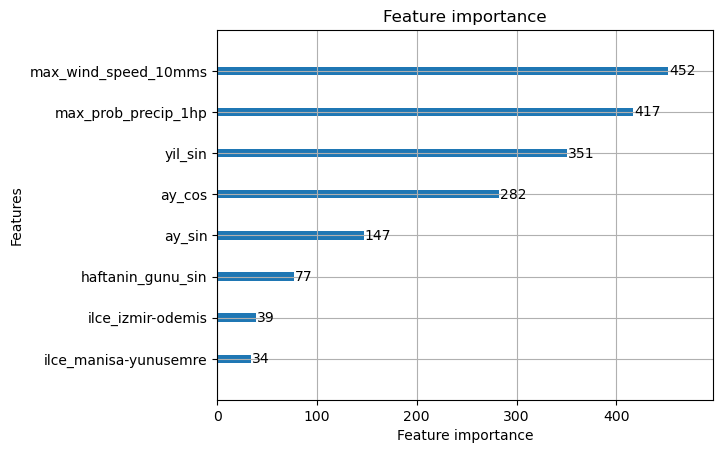

In [23]:
ax = lgb.plot_importance(lgbm_model,max_num_features=8)
plt.show()

In [24]:
test["bildirimsiz_sum"] = lgbm_model.predict(test_df)
test["bildirimsiz_sum"]=test["bildirimsiz_sum"].astype("int")
test["unique_id"]=[str(test["tarih"][i])+"-"+str(test["ilce"][i]) for i in range(0,len(test))]
predict=pd.DataFrame()
predict=test[["unique_id","bildirimsiz_sum"]]
predict["bildirimsiz_sum"]=test["bildirimsiz_sum"]
submission1=pd.merge(submission,predict,how="left",on="unique_id")
submission1.drop("bildirimsiz_sum_x",axis=1,inplace=True)
submission1.columns=["unique_id","bildirimsiz_sum"]
print(submission1.isnull().sum())
submission1.head()

unique_id          0
bildirimsiz_sum    0
dtype: int64


C:\Users\Dell\AppData\Local\Temp\ipykernel_20128\1811979814.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict["bildirimsiz_sum"]=test["bildirimsiz_sum"]


,unique_id,bildirimsiz_sum
0,2024-02-01-izmir-aliaga,4
1,2024-02-01-izmir-bayindir,3
2,2024-02-01-izmir-bayrakli,3
3,2024-02-01-izmir-bergama,4
4,2024-02-01-izmir-bornova,8


In [25]:
submission1.to_csv("C:\\Users\\Dell\\Desktop\\GDZ Elektrik Datathon\\GDZ-Tahmin 21-LightGBM.csv",index=False)

In [26]:
params = {"random_state": 14,
          "n_estimators": 6000,
          "max_depth": 3,
          "objective":"regression",
          "verbose":2,
          "learning_rate": 0.1,
          "subsample": 0.6,
          "num_leaves": 5}
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
gbm = lgb.train(params, lgb_train, valid_sets=lgb_eval, callbacks=[lgb.early_stopping(stopping_rounds=5)])

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.095740
[LightGBM] [Debug] init for col-wise cost 0.000004 seconds, init for row-wise cost 0.000738 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 522
[LightGBM] [Info] Number of data points in the train set: 42330, number of used features: 55
[LightGBM] [Info] Start training from score 5.321214
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
Training until validation scores don't improve for 5 rounds
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 5 and depth = 3
[LightGBM] [Debug] Trained a tree with leaves = 5 and dep

C:\Users\Dell\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [27]:
y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
print("MAE: ",mean_absolute_error(y_test,y_pred))

MAE:  3.001635370802595


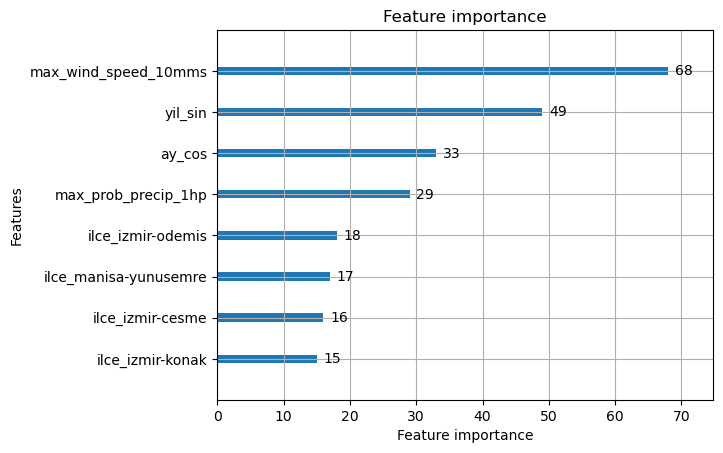

In [28]:
ax = lgb.plot_importance(gbm,max_num_features=8)
plt.show()

In [29]:
test["bildirimsiz_sum"] = gbm.predict(test_df,num_iteration=gbm.best_iteration)
test["bildirimsiz_sum"]=test["bildirimsiz_sum"].astype("int")
test["unique_id"]=[str(test["tarih"][i])+"-"+str(test["ilce"][i]) for i in range(0,len(test))]
predict=pd.DataFrame()
predict=test[["unique_id","bildirimsiz_sum"]]
predict["bildirimsiz_sum"]=test["bildirimsiz_sum"]
submission2=pd.merge(submission,predict,how="left",on="unique_id")
submission2.drop("bildirimsiz_sum_x",axis=1,inplace=True)
submission2.columns=["unique_id","bildirimsiz_sum"]
print(submission2.isnull().sum())
submission2.head()

unique_id          0
bildirimsiz_sum    0
dtype: int64


C:\Users\Dell\AppData\Local\Temp\ipykernel_20128\1781531495.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict["bildirimsiz_sum"]=test["bildirimsiz_sum"]


,unique_id,bildirimsiz_sum
0,2024-02-01-izmir-aliaga,4
1,2024-02-01-izmir-bayindir,4
2,2024-02-01-izmir-bayrakli,4
3,2024-02-01-izmir-bergama,4
4,2024-02-01-izmir-bornova,7


In [30]:
submission2.to_csv("C:\\Users\\Dell\\Desktop\\GDZ Elektrik Datathon\\GDZ-Tahmin 22-LightGBM.csv",index=False)